## Introduction/Background
The goal of the project is to generate news headlines from the text of an article. This is a __text summarization__ problem, as the headline of an article should be a one to two sentence summary of what the reader should expect to read in the article. The data set I will be using, nyt_news, was created using news-please, a news web-scraper. The web-scraper is provided a url(s) and searches those sites for articles, then saves the articles as an HTML file, and a JSON file. For my project I used https://www.nytimes.com as the URL to scrape. While news-please creates many fields from the website, the fields I used from the dataset are _title_ and _maintext_, which represent the titles of news articles and the text content of the article.


## Exploratory Data Analysis
Let's start by loading the data and looking at what news-scraper produced.

In [11]:
# import all of the python modules/packages you'll need here
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

df = pd.read_csv('nytimes_news.csv') # Load the dataset from a CSV
print(df.head())

   Unnamed: 0                           authors        date_download  \
0           0                   ['John Leland']  2022-10-25 23:38:21   
1           0                                []  2022-10-25 23:47:05   
2           0                  ['Eric Schmitt']  2022-10-25 23:53:44   
3           0  ['Elena Bergeron', 'Ken Belson']  2022-10-25 23:28:05   
4           0               ['Nick Corasaniti']  2022-10-25 23:27:22   

           date_modify         date_publish  \
0  2022-10-25 23:38:21  2011-12-17 02:07:26   
1  2022-10-25 23:47:05  2019-08-16 13:53:18   
2  2022-10-25 23:53:44  2018-10-27 14:44:43   
3  2022-10-25 23:28:05  2020-10-03 16:06:18   
4  2022-10-25 23:27:22  2021-03-25 21:31:32   

                                         description  \
0  Dennis Crowley, a co-founder of the social net...   
1                                                NaN   
2  Defense Secretary Jim Mattis’s remarks reflect...   
3  Cam Newton was among those who tested positive...   
4  T

We start by cleaning our data, removing columns produced by new-scraper we definitely do not need in the future, and removing null values for maintext and title (article text and headlines respectively).

In [12]:
# Here we clean the data.
df = df.dropna(subset =['title', 'maintext']) # remove entries where the title or maintext are missing.
df = df.drop(columns=['Unnamed: 0','date_download','date_modify','date_publish','authors','filename','image_url','localpath','title_rss','source_domain','url','site','title_page'])
df.head()

,description,language,title,maintext
0,"Dennis Crowley, a co-founder of the social net...",en,"On Sundays, Foursquare Co-founder Goes Online,...",NIBBLE OF NEW YORK I don’t have a set schedule...
2,Defense Secretary Jim Mattis’s remarks reflect...,en,Mattis Vows U.S. Will Hold Khashoggi’s Killers...,Mr. Trump did not elaborate on the conversatio...
3,Cam Newton was among those who tested positive...,en,Patriots-Chiefs Game Postponed After Positive ...,The league has followed Major League Baseball ...
4,"The law, which has been denounced by Democrats...",en,Georgia G.O.P. Passes Major Law to Limit Voting,"In brief remarks on Thursday evening, Mr. Kemp..."
5,I’m the art editor at The Times. Here are five...,en,What’s in Our Queue? Young Fathers and More,What’s in Our Queue? Young Fathers and More Ba...


Now let's look at our data. Run the cell below to see some statistics of maintext, the article text we are most concerned with since we will be summarizing it with a headline.

In [13]:
df.maintext.describe()

count                                                 11157
unique                                                10819
top       Send any friend a story\nAs a subscriber, you ...
freq                                                     18
Name: maintext, dtype: object

Let's look at some information on the length of an article, by character length.

Here is the number of words in an article.

<AxesSubplot:ylabel='Frequency'>

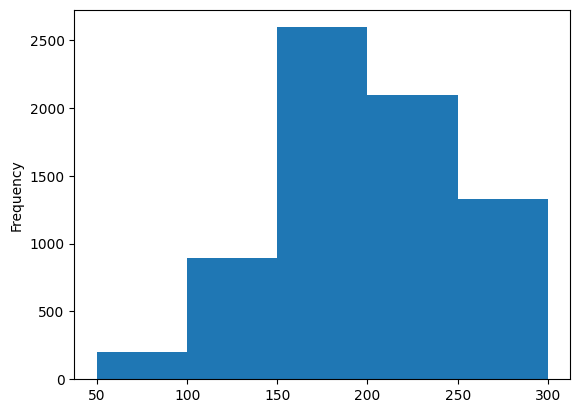

In [14]:
df.maintext.str.split().\
    map(lambda x: len(x)).\
    plot(ylabel='articles', xlabel='sentences', kind= 'hist', bins= [50, 100, 150, 200, 250, 300])

The most common words in an article are (surprise) stop words. We will keep them though because they are an important part of language, and we want to eventually create headlines that make sense.

<BarContainer object of 10 artists>

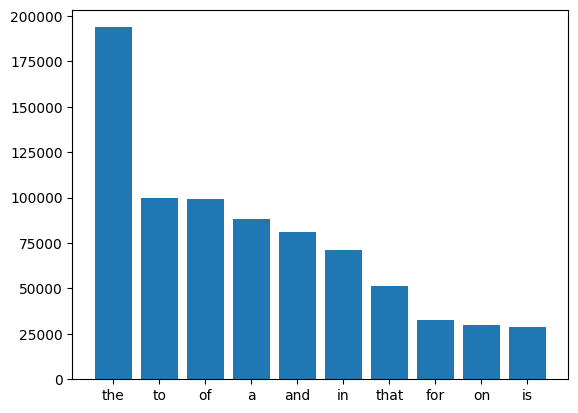

In [15]:
stop=set(stopwords.words('english'))
corpus=[]
new= df['maintext'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top)
plt.bar(x,y)

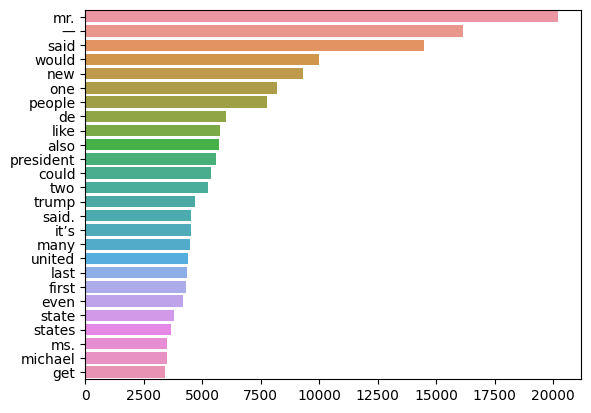

In [16]:

def plot_top_non_stopwords_barchart(text):
    stops=set(stopwords.words('english'))

    new= text.str.lower()
    new= new.str.split()
    new= new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:100]:
        if word not in stops:
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(df['maintext'])

## Tokenization

Here we start to tokenize our article text.

In [17]:
df['raw_tokens'] = df['maintext'].apply(lambda x: word_tokenize(x.lower()))
# df['raw_tokens'] = df['maintext'].apply(lambda x: x.split()) # used whitespace tokenization for now because nltk is being rude.
df.head()

,description,language,title,maintext,raw_tokens
0,"Dennis Crowley, a co-founder of the social net...",en,"On Sundays, Foursquare Co-founder Goes Online,...",NIBBLE OF NEW YORK I don’t have a set schedule...,"[nibble, of, new, york, i, don, ’, t, have, a,..."
2,Defense Secretary Jim Mattis’s remarks reflect...,en,Mattis Vows U.S. Will Hold Khashoggi’s Killers...,Mr. Trump did not elaborate on the conversatio...,"[mr., trump, did, not, elaborate, on, the, con..."
3,Cam Newton was among those who tested positive...,en,Patriots-Chiefs Game Postponed After Positive ...,The league has followed Major League Baseball ...,"[the, league, has, followed, major, league, ba..."
4,"The law, which has been denounced by Democrats...",en,Georgia G.O.P. Passes Major Law to Limit Voting,"In brief remarks on Thursday evening, Mr. Kemp...","[in, brief, remarks, on, thursday, evening, ,,..."
5,I’m the art editor at The Times. Here are five...,en,What’s in Our Queue? Young Fathers and More,What’s in Our Queue? Young Fathers and More Ba...,"[what, ’, s, in, our, queue, ?, young, fathers..."


Next we remove punctuation. I left in stop words because they are needed in actual readable text generation. One issue I had is removing ' s, but I might want to find a way to preserve contractions (don't) actually. 

In [18]:
# from nltk.corpus import stopwords
# Code by sgeinitz, https://github.com/sgeinitz/cs39aa_notebooks/blob/main/nb_C_airline_tweets_take2.ipynb
# Thank you!
# stops = set(stopwords.words('english'))
chars2remove = set(['.','!','/', '?', '\'', ','])
# df['raw_tokens'] = df['raw_tokens'].apply(lambda x: [w for w in x if w not in stops])
df['raw_tokens'] = df['raw_tokens'].apply(lambda x: [w for w in x if w not in chars2remove])
# df['raw_tokens'] = df['raw_tokens'].apply(lambda x: [w for w in x if not re.match('^#', w)])
df.head()

,description,language,title,maintext,raw_tokens
0,"Dennis Crowley, a co-founder of the social net...",en,"On Sundays, Foursquare Co-founder Goes Online,...",NIBBLE OF NEW YORK I don’t have a set schedule...,"[nibble, of, new, york, i, don, ’, t, have, a,..."
2,Defense Secretary Jim Mattis’s remarks reflect...,en,Mattis Vows U.S. Will Hold Khashoggi’s Killers...,Mr. Trump did not elaborate on the conversatio...,"[mr., trump, did, not, elaborate, on, the, con..."
3,Cam Newton was among those who tested positive...,en,Patriots-Chiefs Game Postponed After Positive ...,The league has followed Major League Baseball ...,"[the, league, has, followed, major, league, ba..."
4,"The law, which has been denounced by Democrats...",en,Georgia G.O.P. Passes Major Law to Limit Voting,"In brief remarks on Thursday evening, Mr. Kemp...","[in, brief, remarks, on, thursday, evening, mr..."
5,I’m the art editor at The Times. Here are five...,en,What’s in Our Queue? Young Fathers and More,What’s in Our Queue? Young Fathers and More Ba...,"[what, ’, s, in, our, queue, young, fathers, a..."


__Here are the tokens!__

In [19]:
df['raw_tokens']

0        [nibble, of, new, york, i, don, ’, t, have, a,...
2        [mr., trump, did, not, elaborate, on, the, con...
3        [the, league, has, followed, major, league, ba...
4        [in, brief, remarks, on, thursday, evening, mr...
5        [what, ’, s, in, our, queue, young, fathers, a...
                               ...                        
11405    [shooting, in, midtown, manhattan, new, york, ...
11406    [archived, recording, (, gov, andrew, cuomo, )...
11407    [education, officials, in, new, york, city, on...
11408    [mr., flug, who, heads, both, the, beekman, hi...
11409    [in, the, more, than, six, years, since, his, ...
Name: raw_tokens, Length: 11157, dtype: object